# Initial eda for Postmates project
- import data
- check and adjust data types
- add any new cols (ex. time to deliver)
- summarize dataset using pandas profiling (added to bottom of workbook)
### What would I want to know about New York?
- Daily deliveries
- Weekly, Daily, Demand Fluctuation
- Time to Order and Distribution of times around the mean
- From where are people ordering
- From where are we making the most money? avg. order price, avg. home cost in vascininity #no monetary data
- what merchants get the most traffic
- who's ordering the most
- when are people ordering meals #time of day didn't seem too important for analysis



## Questions:
1. when_the_delivery_started means when the postmate received the call or when they were picking that up from a restaurant

In [1]:
root_path = '/Users/ginariddle/Desktop/g.school/my_projects/jumpman' 
source = 'src'   
data = 'data'  

import os   
import math  
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import pandas_profiling 
from uszipcode import Zipcode
import matplotlib.pyplot as plt
from uszipcode import SearchEngine  

from geopy.distance import distance
from datetime import datetime
import googlemaps
import gmaps

os.chdir(os.path.join(root_path,source))
from functions import (get_loc_data,
                       change_to_timedelta,
                       df_clean,
                       df_preprocess,
                       df_final_add_dropoff_zip)
from lists import mode_dict, df_final_cols,df_delivery_cols

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
os.chdir(root_path)
with open('data/api_key.txt') as f:
    api_key = f.readline()
    
googlem = googlemaps.Client(key=api_key)
gmaps.configure(api_key=api_key)

new_york_coordinates = (40.75, -74.00)

In [326]:
gmaps.figure(center=new_york_coordinates, zoom_level=8,display_toolbar=True)

Figure(layout=FigureLayout(height='420px'))

### Original DF Cleanup
- adding pickup and dropoff zipcode specific data
- cleaning datatypes

In [3]:
# import data
df = pd.read_csv('data/analyze_me.csv')
# Initial preprocessing (adds cols and changes datatypes)
df = df_preprocess(df)
# Cleans preprocessed df and preps for df_final 
df = df_clean(df)

# df.to_pickle(root_path,data,'df_final.pickle')

## DF_Final (Item lvl detail)
- finalize df_final
- groupby delivery_id to create df_delivery base df
- save base delivery df to pickle

In [312]:
df_final = pd.read_pickle('data/df_final.pickle')
df_final = df_final_add_dropoff_zip(df_final).drop_duplicates()



values = {'place_category':'None',
          'median_income':0,
          'median_home_value':0,
          'median_home_value_dropoff':0,
          'pop_density':0,
          'how_long_it_took_to_order':0,
          'time_start_to_pickup':0,
          'time_pickup_arrival_to_depart':0,
          'time_pickup_depart_to_dropoff':0,
          'when_the_Jumpman_arrived_at_pickup':pd.Timestamp(0),
          'when_the_Jumpman_left_pickup':pd.Timestamp(0)}

df_final_incorrect = df_final.copy()
df_final = df_final.fillna(value=values)

In [313]:
df_final.shape

(5967, 38)

In [314]:
df_delivery = df_final.groupby(df_delivery_cols)[['item_quantity']].sum().reset_index().replace(0,np.nan)
df_delivery_incorrect = df_final_incorrect.groupby(df_delivery_cols)[['item_quantity']].sum().reset_index()
df_delivery.to_pickle(os.path.join(root_path,data,'df_delivery.pickle'))

## df_delivery: What deliveries to exclude from high lvl metrics
- Jumpman23 business model is focused on their core product of deliverying readied meals to customers within a range of a few miles in urban areas
- What is 99th percentile of the distance traveled by Jumpmen?
- We test and find that 99% of all deliveries are delivered within a 10 mile range, 75% within a 2 mile range 50% within a one mile range. We therefore cut off all deliveries with a distance traveled > 10 miles and count them as outliers
- Once cleaned, finalize new df called df_delivery_lt_11

In [317]:
df_delivery = pd.read_pickle('data/df_delivery.pickle')
sns.set(style="white", palette="muted", color_codes=True)

In [318]:
fig,ax = plt.subplots(figsize=(13,6))
y = []
means = []
n = 0
y_val = 0
mean_miles = 0
y.append(y_val)
means.append(mean_miles)
while y_val <.99:
    n += 1
    y_val = df_delivery.query(f'distance_traveled < {n}').shape[0]/(df_delivery.shape[0])
    mean_miles = round(df_delivery.query(f'distance_traveled < {n}')['distance_traveled'].mean(),2)
    y.append(y_val)
    means.append(mean_miles)
plt.plot(range(n+1),y,color='black',alpha=.8)
plt.xlabel('miles traveled',fontsize=15)
plt.xlim(0,n+1)
plt.axvline(n,color='r',linestyle='--')
plt.ylabel('% of total deliveries',fontsize=15)
plt.title('Finding the 99th percentile # of miles traveled',fontsize=18)
plt.text(n-2,y[-1]-.059,f"Average Miles: {means[-1]}",horizontalalignment='left',fontsize=15)

print(n)

df_delivery_lt_11 = df_delivery.query(f'distance_traveled < {n}')


10


#### The below chart displays clearly how the avg. delivery distance is biased by outliers
- There is a clear elbow in the graph signifying the 99th percentile of rides we care about
- Removing 1% outliers reduces the average distance traveled from 4.6 to 1.6. A significant difference

In [319]:
fig,ax = plt.subplots(figsize=(4,6))
means = []
for i in range(500):
    mean_miles = round(df_delivery.query(f'distance_traveled < {i}')['distance_traveled'].mean(),2)
    means.append(mean_miles)
plt.plot(means,range(500),color='black',alpha=.8)
plt.ylabel('Delivery Distance Range Increase',fontsize=15)
plt.xlabel('Avg. Delivery Distance',fontsize=15)
plt.title('Change in Avg. Delivery Distance',fontsize=18)

Text(0.5, 1.0, 'Change in Avg. Delivery Distance')

### High Level Aggregate Calculations
- Average time start to pickup
- Average time pickup arrival to departure
- Average time pickup departure to dropoff
- Average Exp. time from pickup departure to dropoff (calculated via the googlemaps api)

In [320]:
avg_time_start_to_pickup = df_delivery_lt_11.query('time_start_to_pickup > 0')['time_start_to_pickup'].mean()
avg_time_pickup_arrival_to_depart = df_delivery_lt_11[df_delivery_lt_11['time_pickup_arrival_to_depart'] > 0]['time_pickup_arrival_to_depart'].mean()
avg_time_pickup_dropoff = df_delivery_lt_11[df_delivery_lt_11['time_pickup_depart_to_dropoff'] > 0]['time_pickup_depart_to_dropoff'].mean()
avg_exp_time_pickup_dropoff = df_delivery_lt_11[df_delivery_lt_11['exp_duration'] > 0]['exp_duration'].mean()
print('Avg distance from pickup to drop: \t\t', round(df_delivery_lt_11['distance_traveled'].mean(),3),'\t',round(df_delivery_lt_11['distance_traveled'].mean(),3))
print('Avg time start to pickup: \t\t\t',round(avg_time_start_to_pickup,2))
print('Avg time pickup arrival to depart: \t\t',round(avg_time_pickup_arrival_to_depart,2))
print('Avg time from pickup depart to drop: \t\t',round(avg_time_pickup_dropoff,2))
print('Avg expected time from pickup depart to drop: \t',round(avg_exp_time_pickup_dropoff,2))
print('Avg time diff from pickup depart to drop: \t',round(avg_time_pickup_dropoff - avg_exp_time_pickup_dropoff,2))
print('Avg delivery time: \t\t\t\t',round(avg_time_start_to_pickup+avg_time_pickup_arrival_to_depart+avg_time_pickup_dropoff,2))

Avg distance from pickup to drop: 		 1.601 	 1.601
Avg time start to pickup: 			 14.18
Avg time pickup arrival to depart: 		 17.75
Avg time from pickup depart to drop: 		 13.56
Avg expected time from pickup depart to drop: 	 10.95
Avg time diff from pickup depart to drop: 	 2.61
Avg delivery time: 				 45.49


In [321]:
fig,ax = plt.subplots(figsize=(30,7))
sns.distplot(df_delivery_lt_11['total_time_to_deliver'],hist=False,color='grey')
ax.set_xlim(0,100)
ax.set_xlabel('Total Time to Deliver',fontsize=20)
ax.set_xticks(list(range(100))[::5])
plt.rc('xtick',labelsize=15)
ax.axvline()

- comments below used for testing

In [57]:
# for i in np.linspace(0,100,101):
#     print(i,df_delivery_lt_11['total_time_to_deliver'].gt(i).mean())

In [1650]:
# for i in np.linspace(0,10,100):
#     print(i,df_delivery_lt_11['distance_traveled'].gt(i).mean())

#### Graph of distribution of distance traveled (by miles)
- p: percentile
- used in presi

In [329]:
percentiles = ['50%','75%','90%','95%']
miles = [1.15,2,3.1,4.24]
sns.set(style="white", palette="muted", color_codes=True)
fig,ax = plt.subplots(figsize=(9,6))
sns.distplot(df_delivery_lt_11['distance_traveled'],bins=30,color='grey',label='p for percentile')
plt.text(3,.62,'Distance Traveled',fontsize=18,horizontalalignment='center')
plt.xlabel('Distance Traveled (Miles)',fontsize=15)
ax.set_xticks(range(7))
plt.xticks(fontsize=15)
plt.legend(fontsize=15)

for i in range(len(miles)):
    plt.axvline(miles[i],linewidth=1,linestyle='--',alpha=.75,color='r')
    plt.text(miles[i],.58,percentiles[i] + ' p',horizontalalignment='center',fontsize=15)
    
plt.xlim(0,6)

(0, 6)

In [329]:
df_delivery_lt_11.to_excel(os.path.join(root_path,data,'df_delivery_lt_11.xls'))

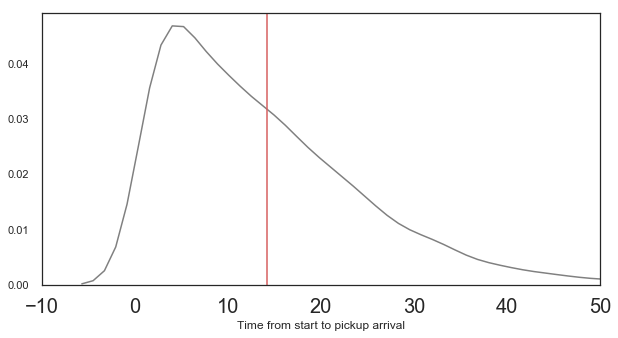

In [1194]:

# percentiles=['50%','75%','95%','99%']
# times = [11,20,35,49]
fig,ax = plt.subplots(figsize=(10,5))
sns.distplot(df_delivery_lt_11.query('time_start_to_pickup > 0')['time_start_to_pickup'],
             bins=30,color='grey',hist=False,ax=ax)
# ax.text(avg_time_start_to_pickup,.002,f'Avg time: {round(avg_time_start_to_pickup)} min',fontsize=15,horizontalalignment='center')
ax.set_xlabel('Time from start to pickup arrival')
plt.xlim(-10,50)
plt.axvline(avg_time_start_to_pickup,linewidth=1.5,alpha=1,color='r')
  


In [1651]:
# for i in np.linspace(0,50,101):
#     print(round(i,2),round(df_delivery_lt_11['time_pickup_arrival_to_depart'].dropna().gt(i).mean(),2))

In [332]:
percentiles = ['50%','75%','90%','95%']
miles = [14.75,22,31.75,38]
fig,ax = plt.subplots(figsize=(12,6))
sns.distplot(df_delivery_lt_11['time_pickup_arrival_to_depart'],
             bins=50,color='grey',ax=ax,label='p for percentile')
# ax.text(avg_time_pickup_arrival_to_depart,.002,f'Avg time: {round(avg_time_pickup_arrival_to_depart)} min',fontsize=15,horizontalalignment='center')
ax.set_xlabel('Time from Pickup Arrival to Departure')
plt.xlim(0,60)
# plt.axvline(avg_time_pickup_arrival_to_depart,linewidth=4,alpha=.75,color='y')
plt.text(30,.063,'Pickup Wait Time Distribution',fontsize=18,horizontalalignment='center')
plt.text(19,.001,f"{round(avg_time_pickup_arrival_to_depart,2)} 'average wait'",fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Time from Pickup Arrival to Departure',fontsize=15)
plt.legend(fontsize=15)
for i in range(len(miles)):
    plt.axvline(miles[i],linewidth=1,linestyle='--',alpha=1,color='r')
    plt.text(miles[i],.058,percentiles[i] + ' p',horizontalalignment='center',fontsize=15)
    
    
  

## Using RandomForest to identify most important features in determining duration of wait at pickup
- This should be considered of upmost importance to create as attractive an option as possible for Jumpmen

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
rf = RandomForestRegressor()
df_delivery_lt_11.dropna().shape

In [1598]:
values = {'item_quantity':1,
          'median_income':df_delivery_lt_11['median_income'].mean(),
          'median_home_value':df_delivery_lt_11['median_home_value'].mean(),
          'pop':df_delivery_lt_11['pop'].mean(),
          'pop_density':df_delivery_lt_11['pop_density'].mean(),
          'how_long_it_took_to_order':df_delivery_lt_11['how_long_it_took_to_order'].mean()}

features_df = df_delivery_lt_11.drop(['when_the_delivery_started',
#                         'when_the_Jumpman_arrived_at_pickup',
                        'when_the_Jumpman_left_pickup',
                        'when_the_Jumpman_arrived_at_dropoff',
                        'when_the_Jumpman_arrived_at_pickup',
                        'total_time_to_deliver',
                        'time_pickup_depart_to_dropoff',
                        'time_start_to_pickup','delivery_id','customer_id'],axis=1)
features_df = features_df.fillna(value=values).dropna()
features_df = pd.get_dummies(features_df)

#### Removing Time data from Dataset for RF training
- After removing time of travel data from dataset and re-running random forest algorithm, the predicted Mean Absolute Error is hardly better than the baseline by taking the average
- New predicted MAE = 7.3 compared to a baseline of 8.18. Not significant

In [1599]:
np.random.seed(3)
y = features_df['time_pickup_arrival_to_depart']
X = features_df.drop('time_pickup_arrival_to_depart',axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)

mean_absolute_error(y_test,y_pred), mean_absolute_error(y_test,[y_train.mean() for i in range(len(y_test))])

(7.309936766034326, 8.185288369861798)

In [1601]:
important_features = pd.DataFrame(rf.feature_importances_,
                                            index=X.columns).sort_values(0,ascending=False).iloc[:20]

important_features

0
jumpman_id                        0.137550
dropoff_lon                       0.102490
day                               0.087033
place_category_Grocery Store      0.069980
dropoff_lat                       0.048601
how_long_it_took_to_order         0.047993
exp_duration                      0.041903
distance_traveled                 0.034669
item_quantity                     0.033620
weekday_Friday                    0.023218
pickup_lat                        0.022402
pickup_lon                        0.021844
pickup_place_Momofuku Noodle Bar  0.017991
pickup_place_Shake Shack          0.015945
median_home_value                 0.012261
zipcodes_10011                    0.010519
pop_density                       0.010347
weekday_Saturday                  0.007389
land_area_in_sqmi                 0.007089
median_income                     0.006654

### Feature Importance Includin Delivery Time data
- Not to indicate causality but merely to show relationship

In [1535]:
endings = ['st','nd','rd','th','th','th','th','th','th','th']
fig,ax = plt.subplots(figsize=(4,8))
y = important_features[0].values.flatten()
x = list(range(important_features.shape[0]))
plt.barh(x,y,color='grey')
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_yticks(x)
ax.set_xlim(0,.6)
plt.xticks(fontsize=15)
ax.set_yticklabels(important_features['index'],fontsize=15)
for i in range(1,11):
    plt.text(y[i-1],x[i-1],f" {i}{endings[i-1]}")
plt.title('Feature Importances in Predicting Time at Pickup',fontsize=18)
plt.xlabel('Relative Importance in Predicting Feature',fontsize=15)

Text(0.5, 0, 'Relative Importance in Predicting Feature')

### Average pickup arrival to departure time filtered only on 'Grocery Store' place types
- Grocery Store clearly is one determining factor
- Still there aren'y enough Grocery Store deliveries to fully explain the true cause of the wait

In [1542]:
df_delivery_lt_11.query("place_category== 'Grocery Store'")['time_pickup_arrival_to_depart'].mean()

40.252252252252255

In [1477]:
important_features = important_features.reset_index()

# Deliveries: To Dropoff Analysis - Comparison Against Google Durations

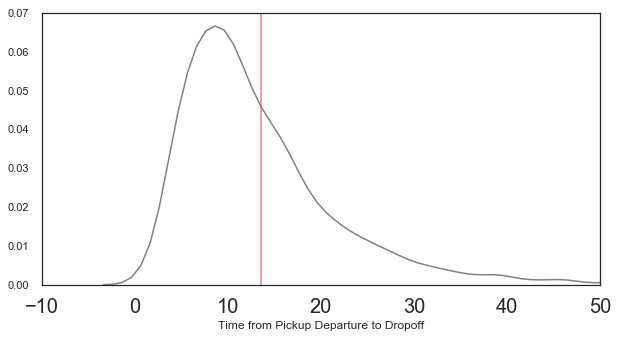

In [1192]:
# percentiles=['50%','75%','95%','99%']
# times = [15,23,39,56]
fig,ax = plt.subplots(figsize=(10,5))
sns.distplot(df_delivery_lt_11['time_pickup_depart_to_dropoff'],
             bins=30,color='grey',hist=False,ax=ax)
# ax.text(avg_time_pickup_dropoff,.002,f'Avg time: {round(avg_time_pickup_dropoff)} min',
#         fontsize=15,horizontalalignment='center')
ax.set_xlabel('Time from Pickup Departure to Dropoff')
plt.xlim(-10,50)
plt.axvline(avg_time_pickup_dropoff,linewidth=1.5,alpha=.75,color='r')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text xticklabel objects>)

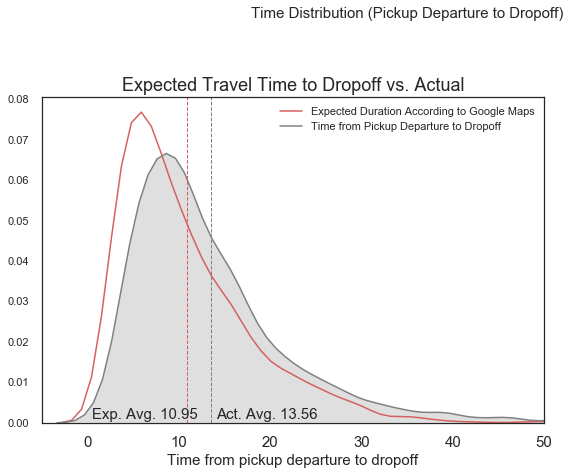

In [1413]:

percentiles=['50%','75%','95%','99%']
times = [15,23,39,56]
fig,ax = plt.subplots(figsize=(9,6))
sns.kdeplot(df_delivery_lt_11['exp_duration'],c='r',label='Expected Duration According to Google Maps')
sns.kdeplot(df_delivery_lt_11['time_pickup_depart_to_dropoff'],
            c='grey',
            shade=True,
            label = 'Time from Pickup Departure to Dropoff')
plt.text(35,.1,'Time Distribution (Pickup Departure to Dropoff)',fontsize=15,horizontalalignment='center')
plt.xlabel('Time from pickup departure to dropoff',fontsize=15)
plt.xlim(-5,50)
# for i in range(len(times)):
#     plt.axvline(times[i],linewidth=.75,linestyle='--',alpha=.75,color='r')
#     plt.text(times[i],.077,percentiles[i] + ' p',horizontalalignment='center',fontsize=13)
plt.axvline(avg_exp_time_pickup_dropoff,color='r',linestyle='--',linewidth=1)
plt.axvline(avg_time_pickup_dropoff,color='grey',linestyle='--',linewidth=1)
plt.text(.5,
         .001,
         f"Exp. Avg. {round(avg_exp_time_pickup_dropoff,2)}",
         horizontalalignment='left',fontsize=15)
plt.text(avg_time_pickup_dropoff+.5,
         .001,
         f"Act. Avg. {round(avg_time_pickup_dropoff,2)}",
         horizontalalignment='left',fontsize=15)
plt.title('Expected Travel Time to Dropoff vs. Actual',fontsize=18)
plt.xticks(fontsize=15)

In [67]:
duration_error = df_delivery_lt_11['time_pickup_depart_to_dropoff']\
    .sub(df_delivery_lt_11['exp_duration']).dropna()

duration_error_minus5 = duration_error.lt(-5).mean()
duration_error_minus5_0 = duration_error.between(-5,0).mean()
duration_error_0_7 = duration_error.between(0.00001,7).mean()
duration_error_7plus = duration_error.gt(7).mean()

In [70]:
duration_error_minus5,duration_error_minus5_0,duration_error_0_7,duration_error_7plus

(0.0574468085106383,
 0.26893617021276595,
 0.5385106382978724,
 0.1351063829787234)

(array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.]),
 <a list of 7 Text xticklabel objects>)

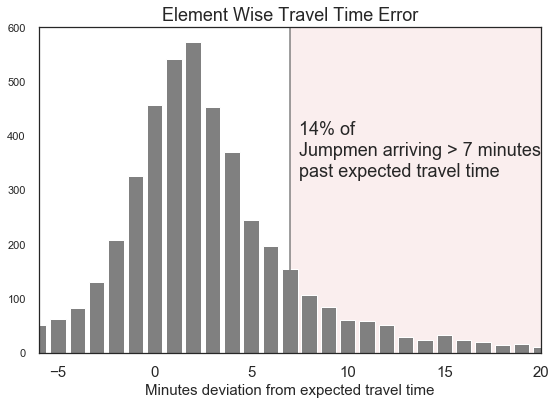

In [58]:
fig,ax = plt.subplots(figsize=(9,6))
ax.axvspan(7, 30, alpha=.1, color='r')
duration_error_value_counts = df_delivery_lt_11['time_pickup_depart_to_dropoff']\
    .sub(df_delivery_lt_11['exp_duration'])\
    .dropna().value_counts().sort_index()
x = duration_error_value_counts.index
y = duration_error_value_counts.values
plt.bar(x,y,color='grey')
plt.xlim(-6,20)
plt.axvline(7,color='grey')
plt.xlabel('Minutes deviation from expected travel time',fontsize=15)
plt.text(7.5,325,f'14% of \nJumpmen arriving > 7 minutes \npast expected travel time',fontsize=18)
# ax.axvspan(-10, -5, alpha=0.5, color='red')
plt.title('Element Wise Travel Time Error',fontsize=18)
plt.xticks(fontsize=15)


In [96]:
error_mask = df_delivery_lt_11['time_pickup_depart_to_dropoff'].sub(df_delivery_lt_11['exp_duration']).dropna()<7

df_delivery_lt_11['time_pickup_depart_to_dropoff'].dropna()[error_mask].mean()

11.172890025575448

# Analyzing Transportation Mode
- No need to use in analysis

In [537]:
df_delivery = pd.read_pickle('data/df_delivery.pickle')

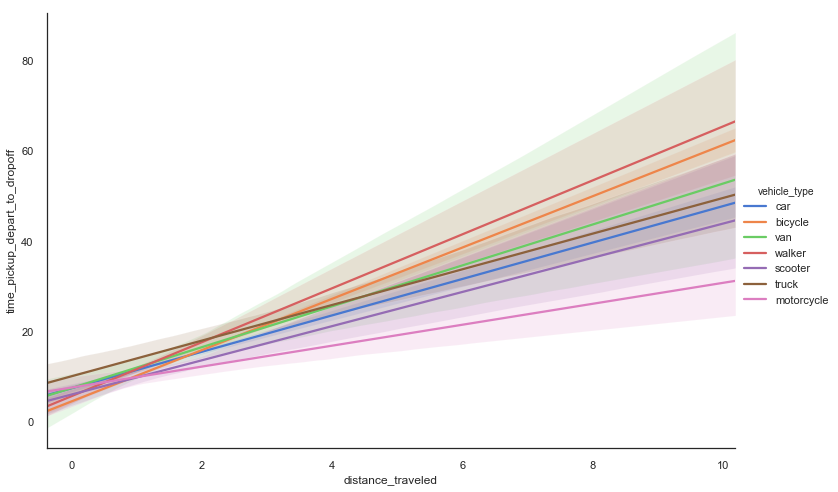

In [38]:
mode = 'walker'
df_distance = df_delivery_lt_11\
    .query(f"vehicle_type == '{mode}'")[['distance_traveled',
                                         'time_pickup_depart_to_dropoff',
                                         'vehicle_type']]
sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',height=7,aspect=1.5,hue='vehicle_type',data = df_delivery_lt_11,scatter=False)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

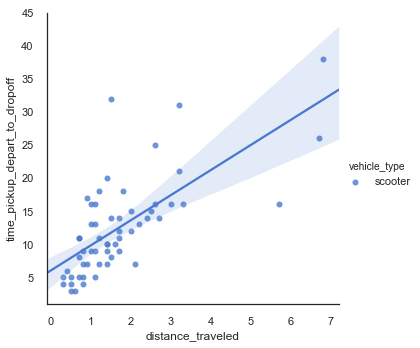

In [1652]:
mode = 'scooter'
df_distance = df_delivery.query('distance_traveled < 12').query(f"vehicle_type == '{mode}'")[['distance_traveled','time_pickup_depart_to_dropoff','vehicle_type']]

sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',hue='vehicle_type',data = df_distance)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

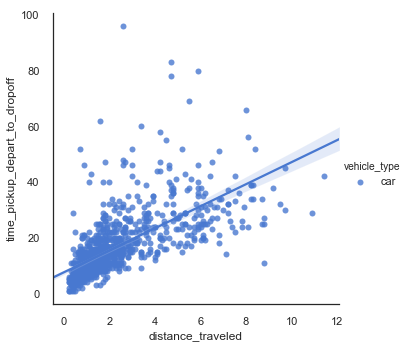

In [1654]:
mode = 'car'
df_distance = df_delivery.query('distance_traveled < 12')\
            .query(f"vehicle_type == '{mode}'")[['distance_traveled',
                                                 'time_pickup_depart_to_dropoff',
                                                 'vehicle_type']]

sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',hue='vehicle_type',data = df_distance)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

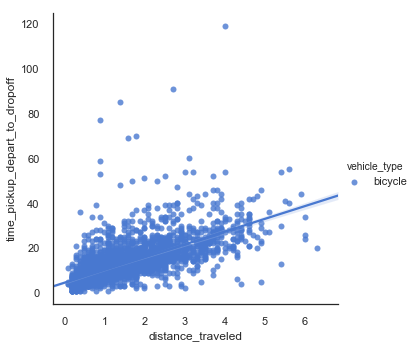

In [1673]:
mode = 'bicycle'
df_distance = df_delivery_lt_11\
            .query(f"vehicle_type == '{mode}'")[['distance_traveled',
                                                 'time_pickup_depart_to_dropoff',
                                                 'vehicle_type']]

sns.lmplot('distance_traveled','time_pickup_depart_to_dropoff',hue='vehicle_type',data = df_distance)
# plt.xlim(-2,10)
# plt.ylim(-10,100)

In [1681]:
transport_modes = df_delivery_lt_11['vehicle_type'].value_counts(normalize=True).round(3)

In [1732]:

# fig,ax = plt.subplots(figsize=(6,6))
sizes = transport_modes.values
labels = transport_modes.index
(transport_modes * 100).round(2)

bicycle       71.6
car           20.3
walker         4.5
van            1.3
scooter        1.2
truck          0.7
motorcycle     0.4
Name: vehicle_type, dtype: float64

In [154]:
jumpmen_df = df_delivery_lt_11[['weekday','jumpman_id','delivery_id','day']]\
                .groupby(['day','weekday'])[['jumpman_id','delivery_id']].nunique()
jumpmen_df['jumper_orders_per_day'] = (jumpmen_df['delivery_id'] / jumpmen_df['jumpman_id']).round(2)

# The Jumpman
- compare number of unique orders compared to active distinct jumpmen. Find avg. delivery count per Jumpman

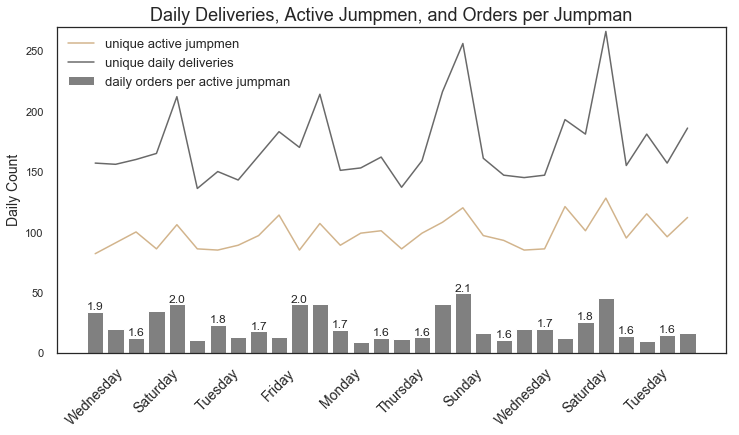

In [337]:
fig,ax = plt.subplots(figsize=(12,6))
y = jumpmen_df['jumpman_id'].values 
y2 = jumpmen_df['delivery_id'].values 
y3 = jumpmen_df['jumper_orders_per_day']
x = list(list(zip(*jumpmen_df['jumpman_id'].index))[0])
plt.plot(x,y,color='tan',label='unique active jumpmen')
plt.plot(x,y2,color='dimgrey',label='unique daily deliveries')
plt.bar(x,(y3*70)-100,color='grey',label='daily orders per active jumpman')
plt.legend(fontsize=13)
for i in list(range(1,len(x)+1))[::2]:
    plt.text(i,(y3[i]*70)-98,round(y3.values[i-1],1),horizontalalignment='center',fontsize=12)
ax.set_xticks(x[::3])
ax.set_xticklabels(list(list(zip(*jumpmen_df.index))[1])[::3],rotation=45)
plt.ylim(0,270)
plt.title('Daily Deliveries, Active Jumpmen, and Orders per Jumpman',fontsize=18)
plt.xticks(fontsize=14)
plt.ylabel('Daily Count',fontsize=14)
plt.show()

In [179]:
jumpmen_df.reset_index()['delivery_id'].sum()/jumpmen_df.reset_index()['jumpman_id'].sum()

1.744508279824265

In [176]:
# for i in np.linspace(0,60,121):
#     print(round(i,2),round(df_delivery_lt_11['jumpman_id'].value_counts().gt(i).mean(),2))

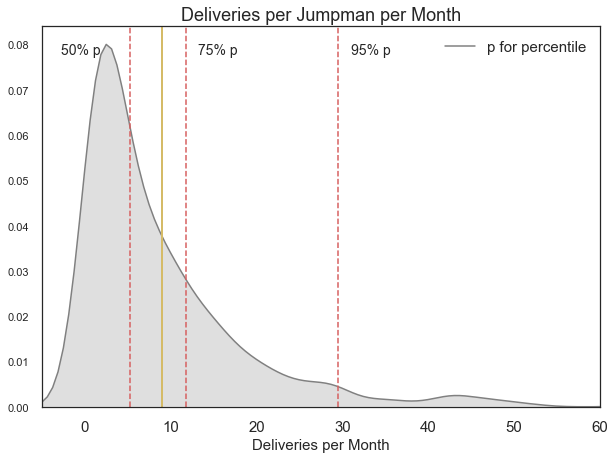

In [346]:
plt.figure(figsize=(10,7))
sns.kdeplot(df_delivery_lt_11['jumpman_id'].value_counts().values,shade=True,color='grey',label='p for percentile')
plt.xlabel('Deliveries per Month',fontsize=15)
plt.title('Deliveries per Jumpman per Month',fontsize=18)
plt.axvline(11.75,linestyle='--',color='r')
plt.axvline(29.5,linestyle='--',color='r')
plt.axvline(5.25,linestyle='--',color='r')
plt.axvline(8.95,linewidth=2,color='y')
plt.text(5.25-8,.078,f"50% p",fontsize=14)
plt.text(11.75+1.5,.078,f"75% p",fontsize=14)
plt.text(29.5+1.5,.078,f"95% p",fontsize=14)
plt.xticks(fontsize=15)
plt.xlim(-5,60)
plt.legend(fontsize=15)


# Related: Test for overall Order, Unique Jumpmen and Restaurant Growth

In [21]:
jumpmen_df = jumpmen_df.reset_index().drop('weekday',axis=1)

In [22]:
week_dict = {}
for i in list(range(0,30)):
    week_dict[i+1] = (i//7)+1
new_col = []
for day in jumpmen_df['day']:
    new_col.append(week_dict[day])

jumpmen_df['week'] = new_col

weekly_orders = np.asarray(jumpmen_df.groupby('week')['delivery_id'].sum().iloc[:4].values.tolist())

In [23]:
def week(day):
    week = week_dict[day]
    return week

df_delivery_lt_11['week'] = df_delivery_lt_11['day'].apply(week)

In [47]:
weekly_orders_per_jumpman = np.asarray([3.81,2.71,3.86,3.82])
weekly_orders_per_restaurant = ['']
fig,ax = plt.subplots(figsize=(11,8))
df_by_week = df_delivery_lt_11.groupby('week')[['jumpman_id','delivery_id','merchant_id','customer_id']].nunique()
df_by_week.columns = ['unique_jumpmen','order_count','unique_merchants','unique_customers']
sns.lineplot(data=df_by_week.iloc[:4],palette=sns.color_palette("Greys", 4),legend='full')
plt.setp(ax.get_legend().get_texts(), fontsize='15')
plt.bar([1,2,3,4],weekly_orders_per_jumpman*50,label='Orders per Jumpman',color='tan')
plt.ylim(-50,2000)
plt.legend(fontsize=13)
plt.xticks([1,2,3,4],fontsize=15)
plt.xlabel('Week',fontsize=15)
plt.ylabel('Unique Order and Jumpman Count',fontsize=15)
plt.text(.5,1790,f"11.4% Jumpmen Growth from W1 to W4",fontsize=15)
plt.text(.5,1630,f"11.6% Order Growth from W1 to W4",fontsize=15)
plt.title('In Month Order and Unique Active Jumpmen Growth',fontsize=18)
for i in range(1,5):
    plt.text(i,(weekly_orders_per_jumpman*50)[i-1]-100,
             f"{weekly_orders_per_jumpman[i-1]} / week",
             horizontalalignment='center',fontsize=13)
for i in [0,-1]:
    plt.text([1,2,3,4][i],df_by_week['unique_jumpmen'].values[:4][i]+40,df_by_week['unique_jumpmen'].values[:4][i])
for i in [0,-1]:
    plt.text([1,2,3,4][i],df_by_week['order_count'].values[:4][i]+40,df_by_week['order_count'].values[:4][i])
for i in [0,-1]:
    plt.text([1,2,3,4][i],df_by_week['unique_merchants'].values[:4][i]+40,df_by_week['unique_merchants'].values[:4][i])
for i in [0,-1]:
    plt.text([1,2,3,4][i],df_by_week['unique_customers'].values[:4][i]+40,df_by_week['unique_customers'].values[:4][i])

SyntaxError: invalid syntax (<ipython-input-47-facdea4420ee>, line 2)

In [38]:
df_delivery_lt_11.groupby('week')[['jumpman_id','delivery_id','merchant_id','customer_id']].nunique()

jumpman_id  delivery_id  merchant_id  customer_id
week                                                   
1            298         1136          476          946
2            317         1177          513          988
3            321         1238          498         1033
4            332         1268          506         1058
5            166          343          221          320

In [49]:
df_delivery_lt_11.groupby('state')[['jumpman_id','delivery_id','merchant_id','customer_id']].nunique()

jumpman_id  delivery_id  merchant_id  customer_id
state                                                   
NY            575         5162         1196         3172

In [308]:
weekly_orders = jumpmen_df.groupby('week')['delivery_id'].sum().iloc[:4].values.tolist()

i = 0
while i <= 51:
    try:
        if weekly_orders[i]:
            i += 1
            pass
    except:
        i+=1
        weekly_orders.append(weekly_orders[i-2] * growth[i-2])

Text(0.5, 1.0, '52 Week Growth: Assuming Growth Stays Constant')

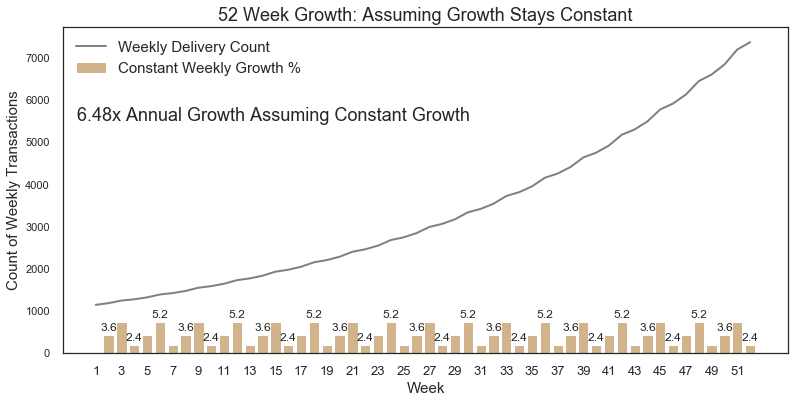

In [323]:
fig,ax = plt.subplots(figsize=(13,6))
weeks = [i for i in range(1,53)]
[i for i in range(len(weeks))]
growth = [0.036092 , 0.051827 , 0.024233] * int((52/3))
growth = np.asarray(growth) + 1
ax.plot(weeks,weekly_orders,color='grey',linewidth=2,label='Weekly Delivery Count')
ax.set_xlabel('Week',fontsize=15)
ax.set_ylabel('Count of Weekly Transactions',fontsize=15)
plt.bar(weeks[1:52],(growth*20000)-20300,color='tan',label='Constant Weekly Growth %')
plt.legend(fontsize=15)
for i in list(range(1,52,2)):
    plt.text(weeks[i],
             (((growth*20000)-20300)+100)[i-1],
             round(((growth-1)*100)[i-1],1),
             horizontalalignment='center',fontsize=12)
ax.set_xticks(weeks[::2])
plt.xticks(fontsize=13)
plt.text(-.5,
         5500,
         f"{round(weekly_orders[-1]/weekly_orders[0],2)}x Annual Growth Assuming Constant Growth" ,
         fontsize=18)
plt.title('52 Week Growth: Assuming Growth Stays Constant',fontsize=18)



# The Order

In [836]:
order_df = df_delivery[['how_long_it_took_to_order','item_quantity']].dropna()

Text(10.5, 0.73, '80% of orders placed within 10 minutes')

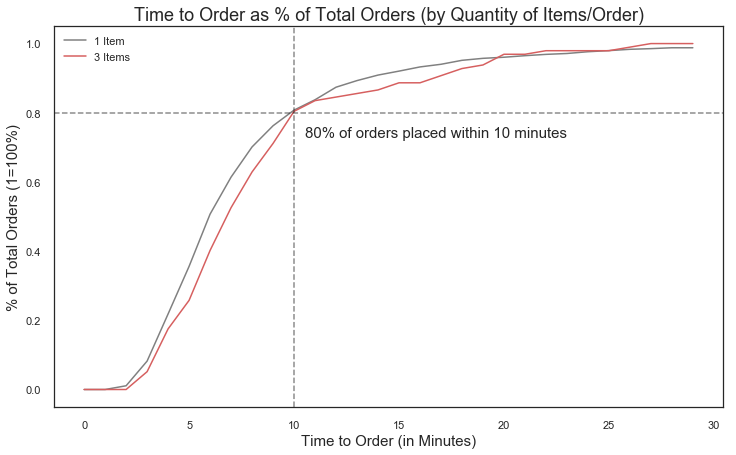

In [307]:
not_nan_mask = ~df_delivery['how_long_it_took_to_order'].isna()
y_3_mask = df_delivery['item_quantity']==3
y_mask = df_delivery['item_quantity']==1
colors = ['grey','r']
x = range(30)
y = []
y_3 = []
y_name = ['1 Item','3 Items']
y_list = [y,y_3]
for i in range(30):
    y.append(df_delivery[not_nan_mask][y_mask]['how_long_it_took_to_order'].lt(i).mean())
    y_3.append(df_delivery[not_nan_mask][y_3_mask]['how_long_it_took_to_order'].lt(i).mean())

    
plt.figure(figsize=(12,7))
for y,name,c in zip(y_list,y_name,colors):
    plt.plot(x,y,label=name,color=c)
plt.axvline(10,color='k',alpha=.5,linestyle='--')
plt.axhline(.8,color='k',alpha=.5,linestyle='--')
plt.legend()
plt.xlabel('Time to Order (in Minutes)',fontsize=15)
plt.ylabel('% of Total Orders (1=100%)',fontsize=15)
plt.title('Time to Order as % of Total Orders (by Quantity of Items/Order)',fontsize=18)
plt.text(10.5,.73,'80% of orders placed within 10 minutes',fontsize=15)

In [573]:
df_delivery['how_long_it_took_to_order'] = df_delivery['how_long_it_took_to_order'][not_nan_mask]

In [934]:
order_time_df = pd.DataFrame(np.asarray([x,y,count_time_by_place_cat.astype(int)]).T,columns=['x','y','hue'])

In [966]:
top_merchants_categories = df_delivery['place_category'].value_counts(normalize=True).round(2)



None                     0.16
Italian                  0.08
Burger                   0.08
American                 0.07
Japanese                 0.06
Dessert                  0.05
Chinese                  0.05
Sushi                    0.04
Salad                    0.04
Mexican                  0.03
Grocery Store            0.02
Bakery                   0.02
BBQ                      0.02
Pizza                    0.02
Juice Bar                0.02
Indian                   0.02
Fast Food                0.02
Donut                    0.01
Seafood                  0.01
Drug Store               0.01
Mediterranean            0.01
Vegetarian               0.01
Coffee                   0.01
Middle Eastern           0.01
Deli                     0.01
Ice Cream                0.01
Gluten-Free              0.01
Breakfast                0.01
Shop                     0.01
South American           0.01
Thai                     0.01
Steak                    0.01
French                   0.00
Southern  

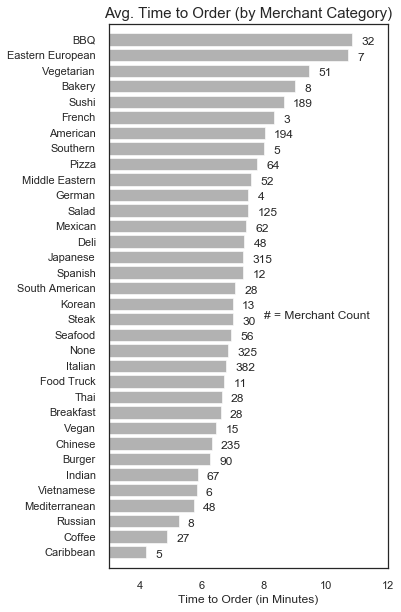

In [957]:
fig,ax = plt.subplots(figsize=(5,10))
time_by_place_cat = df_delivery.groupby('place_category')['how_long_it_took_to_order']\
                    .agg(['count','mean'])\
                    .query('count >2')\
                    .sort_values('mean',ascending=True)

avg_time_by_place_cat = time_by_place_cat['mean']
count_time_by_place_cat = time_by_place_cat['count']

x = avg_time_by_place_cat.values
y = [i for i in range(len(avg_time_by_place_cat))]
sns.barplot('x','y',data=order_time_df,color='grey',orient='h',alpha=.6)
for i in range(len(count_time_by_place_cat)):
    plt.text(avg_time_by_place_cat[i]+.3,y[i]-.35,count_time_by_place_cat[i])
plt.text(8,15,'# = Merchant Count',withdash=True)
ax.set_yticks(y)
ax.set_yticklabels(avg_time_by_place_cat.index)
plt.xlim(3,12)
plt.ylabel('')
plt.ylim(-1,34)
ax.set_xlabel('Time to Order (in Minutes)')
plt.title('Avg. Time to Order (by Merchant Category)',fontsize=15)
plt.show()

In [15]:
df_delivery_lt_11.to_excel(os.path.join(root_path,data,'df_delivery_lt_11.xls'))

In [17]:
# df_delivery_lt_11['merchant_id'] = 
df_delivery_lt_11['merchant_id'] = df_delivery_lt_11['pickup_place'] + df_delivery_lt_11['zipcodes'].apply(str)+df_delivery_lt_11['pickup_lat'].apply(str)

In [14]:
df_delivery_lt_11.to_excel(os.path.join(root_path,data,'df_delivery_lt_11.xls'))

In [285]:
df_delivery_lt_11['place_category'].value_counts(normalize=True).head(11)[1:]

Italian          0.084463
Burger           0.076327
American         0.069159
Japanese         0.064316
Dessert          0.053468
Chinese          0.051143
Sushi            0.039132
Salad            0.037195
Mexican          0.031577
Grocery Store    0.024990
Name: place_category, dtype: float64

In [268]:
ratios = []
x = []
for i in range(df_delivery_lt_11['merchant_id'].value_counts().shape[0]):
    x.append(i)
    ratios.append(df_delivery_lt_11['merchant_id'].value_counts()[:i].sum()\
                  /df_delivery_lt_11['merchant_id'].value_counts().sum())
    print(i,ratios[i])

0 0.0
1 0.022278186749321967
2 0.04339403332041844
3 0.06199147617202635
4 0.07942657884540875
5 0.09666795815575359
6 0.11216582719876017
7 0.1261139093374661
8 0.13967454475009686
9 0.15284773343665245
10 0.16408368849283222
11 0.17512592018597442
12 0.18558698179000388
13 0.19585432003099573
14 0.20592793490895
15 0.21580782642386673
16 0.22568771793878342
17 0.23537388609066254
18 0.24506005424254165
19 0.254165052305308
20 0.2630763270050368
21 0.27140643161565287
22 0.2793490895001937
23 0.28709802402169704
24 0.2948469585432003
25 0.302402169701666
26 0.30976365749709417
27 0.3167376985664471
28 0.32313056954668734
29 0.3291359938008524
30 0.33514141805501746
31 0.34114684230918246
32 0.34695854320030994
33 0.3527702440914374
34 0.3583882216195273
35 0.363618752421542
36 0.36884928322355676
37 0.3740798140255715
38 0.3791166214645486
39 0.3839597055404882
40 0.38860906625339015
41 0.392870980240217
42 0.3971328942270438
43 0.401201084850833
44 0.4052692754746222
45 0.40933746609

370 0.8074389771406432
371 0.8078264238667183
372 0.8082138705927935
373 0.8086013173188686
374 0.8089887640449438
375 0.809376210771019
376 0.8097636574970941
377 0.8101511042231693
378 0.8105385509492444
379 0.8109259976753197
380 0.8113134444013949
381 0.81170089112747
382 0.8120883378535452
383 0.8124757845796203
384 0.8128632313056955
385 0.8132506780317706
386 0.8136381247578458
387 0.814025571483921
388 0.8144130182099961
389 0.8148004649360713
390 0.8151879116621464
391 0.8155753583882216
392 0.8159628051142968
393 0.8163502518403719
394 0.8167376985664471
395 0.8171251452925222
396 0.8175125920185975
397 0.8179000387446727
398 0.8182874854707478
399 0.818674932196823
400 0.8190623789228981
401 0.8194498256489733
402 0.8198372723750484
403 0.8202247191011236
404 0.8206121658271988
405 0.8209996125532739
406 0.8213870592793491
407 0.8217745060054242
408 0.8221619527314994
409 0.8225493994575745
410 0.8229368461836497
411 0.8233242929097249
412 0.8237117396358
413 0.8240991863618

738 0.9112746997287873
739 0.9114684230918249
740 0.9116621464548624
741 0.9118558698179
742 0.9120495931809376
743 0.9122433165439752
744 0.9124370399070127
745 0.9126307632700503
746 0.9128244866330879
747 0.9130182099961255
748 0.9132119333591631
749 0.9134056567222006
750 0.9135993800852383
751 0.9137931034482759
752 0.9139868268113135
753 0.9141805501743511
754 0.9143742735373886
755 0.9145679969004262
756 0.9147617202634638
757 0.9149554436265014
758 0.915149166989539
759 0.9153428903525765
760 0.9155366137156141
761 0.9157303370786517
762 0.9159240604416893
763 0.9161177838047269
764 0.9163115071677644
765 0.916505230530802
766 0.9166989538938396
767 0.9168926772568772
768 0.9170864006199148
769 0.9172801239829523
770 0.9174738473459899
771 0.9176675707090275
772 0.9178612940720651
773 0.9180550174351026
774 0.9182487407981402
775 0.9184424641611778
776 0.9186361875242154
777 0.918829910887253
778 0.9190236342502905
779 0.9192173576133281
780 0.9194110809763657
781 0.91960480433

1101 0.9815962805114297
1102 0.9817900038744672
1103 0.9819837272375048
1104 0.9821774506005424
1105 0.98237117396358
1106 0.9825648973266176
1107 0.9827586206896551
1108 0.9829523440526927
1109 0.9831460674157303
1110 0.9833397907787679
1111 0.9835335141418055
1112 0.983727237504843
1113 0.9839209608678806
1114 0.9841146842309183
1115 0.9843084075939559
1116 0.9845021309569935
1117 0.984695854320031
1118 0.9848895776830686
1119 0.9850833010461062
1120 0.9852770244091438
1121 0.9854707477721814
1122 0.9856644711352189
1123 0.9858581944982565
1124 0.9860519178612941
1125 0.9862456412243317
1126 0.9864393645873692
1127 0.9866330879504068
1128 0.9868268113134444
1129 0.987020534676482
1130 0.9872142580395196
1131 0.9874079814025571
1132 0.9876017047655947
1133 0.9877954281286323
1134 0.9879891514916699
1135 0.9881828748547075
1136 0.988376598217745
1137 0.9885703215807826
1138 0.9887640449438202
1139 0.9889577683068578
1140 0.9891514916698954
1141 0.9893452150329329
1142 0.989538938395970

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

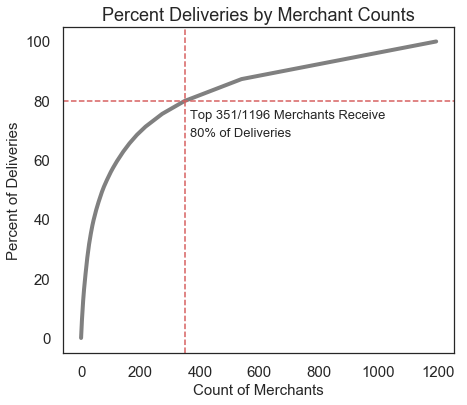

In [278]:
plt.figure(figsize=(7,6))
plt.plot(x,np.asarray(ratios)*100,color='grey',linewidth=4)
plt.ylabel('Percent of Deliveries',fontsize=15)
plt.xlabel('Count of Merchants',fontsize=15)
plt.title('Percent Deliveries by Merchant Counts',fontsize=18)
plt.axhline(80,color='r',linestyle='--')
plt.axvline(351,color='r',linestyle='--')
plt.text(365,74,'Top 351/1196 Merchants Receive',fontsize=13)
plt.text(365,68,'80% of Deliveries',fontsize=13)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [247]:
x = []
y = []
for i in np.linspace(0,100,101):
    x.append(round(i,2))
    y.append(round(df_delivery_lt_11['merchant_id'].value_counts().gt(i).mean(),3))
    


Text(0.02, 56, ' >50 Deliveries per Month')

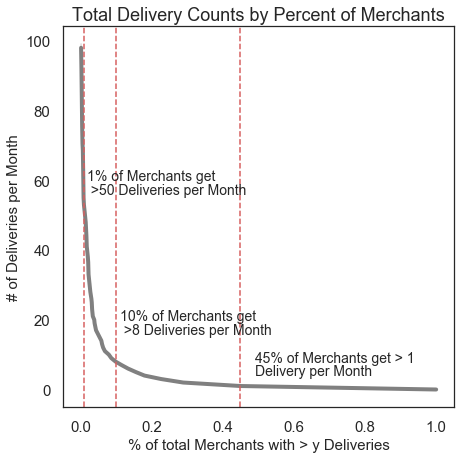

In [257]:
plt.figure(figsize=(7,7))
sns.lineplot(y,x,color='Grey',linewidth=4)
plt.xlabel('% of total Merchants with > y Deliveries',fontsize=15)
plt.ylabel('# of Deliveries per Month',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Total Delivery Counts by Percent of Merchants',fontsize=18)
plt.axvline(.45,linestyle='--',color='r')
plt.axvline(.1,linestyle='--',color='r')
plt.text(.11,20,'10% of Merchants get',fontsize=14)
plt.text(.11,16,' >8 Deliveries per Month',fontsize=14)
plt.text(.49,8,'45% of Merchants get > 1',fontsize=14)
plt.text(.49,4,'Delivery per Month',fontsize=14)
# plt.axvline(,linestyle='--',color='r')
plt.axvline(.01,linestyle='--',color='r')
plt.text(.02,60,'1% of Merchants get',fontsize=14)
plt.text(.02,56,' >50 Deliveries per Month',fontsize=14)

In [253]:
df_delivery_lt_11['place_category'].unique()

array(['Unknown', 'Drug Store', 'Fast Food', 'American',
       'Convenience Store', 'Grocery Store', 'Juice Bar', 'Coffee',
       'Breakfast', 'Indian', 'Korean', 'Salad', 'BBQ', 'Burger',
       'Mediterranean', 'Asian', 'Seafood', 'Vegetarian', 'Deli',
       'Italian', 'Bakery', 'Mexican', 'Gluten-Free', 'Shop', 'Pizza',
       'Japanese', 'Chinese', 'Middle Eastern', 'Sushi', 'Steak',
       'Ice Cream', 'Southern', 'Thai', 'Dessert', 'Electronics Store',
       'Eastern European', 'Vegan', 'Specialty Store', 'South American',
       'French', 'Donut', 'Spanish', 'Department Store', 'Caribbean',
       'Office Supplies Store', 'Book Store', 'Russian', 'German',
       'Kids & Baby', 'Clothing', 'Vietnamese', 'Food Truck',
       'Beauty Supply', 'Pet Supplies Store', 'Promo', 'African',
       'Restaurant', 'Art Store'], dtype=object)

In [254]:
non_food = ['Drug_Store','Convenience Store','Grocery Store',
 'Shop','Electronics Store','Specialty Store','Department Store',
 'Office Supplies Store','Clothing','Beauty Supply','Pet Supplies Store','Art Store']

In [256]:
no_food = 0
food = 0
for cat in df_delivery_lt_11['place_category']:
    if cat in non_food:
        no_food +=1
    else:
        food += 1
no_food/(no_food+food),food/(no_food+food)

(0.04416892677256877, 0.9558310732274312)

In [291]:
df_delivery_lt_11['customer_id'].value_counts()

ratios = []
x = []
for i in range(df_delivery_lt_11['customer_id'].value_counts().shape[0]):
    x.append(i)
    ratios.append(df_delivery_lt_11['customer_id'].value_counts()[:i].sum()\
                  /df_delivery_lt_11['customer_id'].value_counts().sum())
    print(i,ratios[i])

0 0.0
1 0.004455637349864394
2 0.0077489345215032935
3 0.010654784967067028
4 0.01336691204959318
5 0.01588531576908175
6 0.01820999612553274
7 0.02053467648198373
8 0.022665633475397132
9 0.024602867105772957
10 0.026540100736148778
11 0.028477334366524602
12 0.030414567996900427
13 0.03235180162727625
14 0.034289035257652076
15 0.036032545524990314
16 0.03777605579232855
17 0.0395195660596668
18 0.04126307632700504
19 0.043006586594343275
20 0.04475009686168152
21 0.04629988376598218
22 0.04784967067028283
23 0.04939945757458349
24 0.05094924447888415
25 0.05249903138318481
26 0.05404881828748547
27 0.05559860519178613
28 0.05714839209608679
29 0.058504455637349864
30 0.05986051917861294
31 0.06121658271987602
32 0.06257264626113909
33 0.06392870980240217
34 0.06528477334366524
35 0.06664083688492832
36 0.0679969004261914
37 0.06935296396745448
38 0.07070902750871755
39 0.07206509104998063
40 0.07342115459124371
41 0.07477721813250678
42 0.07613328167376986
43 0.07729562185199534
44 

352 0.31325067803177065
353 0.3138318481208834
354 0.3144130182099961
355 0.31499418829910886
356 0.3155753583882216
357 0.3161565284773344
358 0.3167376985664471
359 0.31731886865555986
360 0.3179000387446726
361 0.31848120883378533
362 0.3190623789228981
363 0.31964354901201086
364 0.3202247191011236
365 0.32080588919023634
366 0.3213870592793491
367 0.3219682293684618
368 0.3225493994575746
369 0.32313056954668734
370 0.3237117396358001
371 0.3242929097249128
372 0.32487407981402555
373 0.32545524990313834
374 0.3260364199922511
375 0.3266175900813638
376 0.32719876017047655
377 0.3277799302595893
378 0.32836110034870203
379 0.3289422704378148
380 0.32952344052692756
381 0.3301046106160403
382 0.33068578070515303
383 0.33126695079426577
384 0.33184812088337856
385 0.3324292909724913
386 0.33301046106160404
387 0.33359163115071677
388 0.3341728012398295
389 0.33475397132894225
390 0.33533514141805504
391 0.3359163115071678
392 0.3364974815962805
393 0.33707865168539325
394 0.33765982

711 0.47268500581170086
712 0.4730724525377761
713 0.47345989926385124
714 0.4738473459899264
715 0.47423479271600155
716 0.4746222394420767
717 0.47500968616815187
718 0.475397132894227
719 0.4757845796203022
720 0.4761720263463774
721 0.47655947307245256
722 0.4769469197985277
723 0.47733436652460287
724 0.47772181325067803
725 0.4781092599767532
726 0.47849670670282834
727 0.4788841534289035
728 0.4792716001549787
729 0.4796590468810539
730 0.48004649360712903
731 0.4804339403332042
732 0.48082138705927935
733 0.4812088337853545
734 0.48159628051142966
735 0.4819837272375048
736 0.48237117396358
737 0.4827586206896552
738 0.48314606741573035
739 0.4835335141418055
740 0.48392096086788067
741 0.4843084075939558
742 0.484695854320031
743 0.48508330104610614
744 0.4854707477721813
745 0.4858581944982565
746 0.48624564122433167
747 0.48663308795040683
748 0.487020534676482
749 0.48740798140255714
750 0.4877954281286323
751 0.48818287485470746
752 0.4885703215807826
753 0.488957768306857

1085 0.5956993413405657
1086 0.5958930647036033
1087 0.5960867880666408
1088 0.5962805114296784
1089 0.596474234792716
1090 0.5966679581557536
1091 0.5968616815187912
1092 0.5970554048818287
1093 0.5972491282448663
1094 0.5974428516079039
1095 0.5976365749709415
1096 0.597830298333979
1097 0.5980240216970166
1098 0.5982177450600542
1099 0.5984114684230918
1100 0.5986051917861294
1101 0.5987989151491669
1102 0.5989926385122045
1103 0.5991863618752421
1104 0.5993800852382798
1105 0.5995738086013174
1106 0.599767531964355
1107 0.5999612553273925
1108 0.6001549786904301
1109 0.6003487020534677
1110 0.6005424254165053
1111 0.6007361487795428
1112 0.6009298721425804
1113 0.601123595505618
1114 0.6013173188686556
1115 0.6015110422316932
1116 0.6017047655947307
1117 0.6018984889577683
1118 0.6020922123208059
1119 0.6022859356838435
1120 0.602479659046881
1121 0.6026733824099186
1122 0.6028671057729562
1123 0.6030608291359938
1124 0.6032545524990314
1125 0.603448275862069
1126 0.603641999225106

1444 0.6652460286710578
1445 0.6654397520340953
1446 0.6656334753971329
1447 0.6658271987601705
1448 0.6660209221232081
1449 0.6662146454862456
1450 0.6664083688492832
1451 0.6666020922123208
1452 0.6667958155753584
1453 0.666989538938396
1454 0.6671832623014335
1455 0.6673769856644711
1456 0.6675707090275087
1457 0.6677644323905463
1458 0.6679581557535839
1459 0.6681518791166214
1460 0.668345602479659
1461 0.6685393258426966
1462 0.6687330492057342
1463 0.6689267725687718
1464 0.6691204959318093
1465 0.6693142192948469
1466 0.6695079426578845
1467 0.6697016660209221
1468 0.6698953893839598
1469 0.6700891127469973
1470 0.6702828361100349
1471 0.6704765594730725
1472 0.6706702828361101
1473 0.6708640061991477
1474 0.6710577295621852
1475 0.6712514529252228
1476 0.6714451762882604
1477 0.671638899651298
1478 0.6718326230143356
1479 0.6720263463773731
1480 0.6722200697404107
1481 0.6724137931034483
1482 0.6726075164664859
1483 0.6728012398295234
1484 0.672994963192561
1485 0.6731886865555

1800 0.7342115459124371
1801 0.7344052692754747
1802 0.7345989926385122
1803 0.7347927160015498
1804 0.7349864393645874
1805 0.735180162727625
1806 0.7353738860906626
1807 0.7355676094537001
1808 0.7357613328167377
1809 0.7359550561797753
1810 0.7361487795428129
1811 0.7363425029058505
1812 0.736536226268888
1813 0.7367299496319256
1814 0.7369236729949632
1815 0.7371173963580008
1816 0.7373111197210384
1817 0.7375048430840759
1818 0.7376985664471135
1819 0.7378922898101511
1820 0.7380860131731887
1821 0.7382797365362262
1822 0.7384734598992638
1823 0.7386671832623014
1824 0.738860906625339
1825 0.7390546299883766
1826 0.7392483533514141
1827 0.7394420767144517
1828 0.7396358000774893
1829 0.7398295234405269
1830 0.7400232468035645
1831 0.740216970166602
1832 0.7404106935296397
1833 0.7406044168926773
1834 0.7407981402557149
1835 0.7409918636187525
1836 0.74118558698179
1837 0.7413793103448276
1838 0.7415730337078652
1839 0.7417667570709028
1840 0.7419604804339404
1841 0.742154203796977

2186 0.8089887640449438
2187 0.8091824874079814
2188 0.809376210771019
2189 0.8095699341340565
2190 0.8097636574970941
2191 0.8099573808601317
2192 0.8101511042231693
2193 0.8103448275862069
2194 0.8105385509492444
2195 0.810732274312282
2196 0.8109259976753197
2197 0.8111197210383573
2198 0.8113134444013949
2199 0.8115071677644324
2200 0.81170089112747
2201 0.8118946144905076
2202 0.8120883378535452
2203 0.8122820612165828
2204 0.8124757845796203
2205 0.8126695079426579
2206 0.8128632313056955
2207 0.8130569546687331
2208 0.8132506780317706
2209 0.8134444013948082
2210 0.8136381247578458
2211 0.8138318481208834
2212 0.814025571483921
2213 0.8142192948469585
2214 0.8144130182099961
2215 0.8146067415730337
2216 0.8148004649360713
2217 0.8149941882991089
2218 0.8151879116621464
2219 0.815381635025184
2220 0.8155753583882216
2221 0.8157690817512592
2222 0.8159628051142968
2223 0.8161565284773343
2224 0.8163502518403719
2225 0.8165439752034095
2226 0.8167376985664471
2227 0.816931421929484

2572 0.8837659821774506
2573 0.8839597055404882
2574 0.8841534289035258
2575 0.8843471522665634
2576 0.8845408756296009
2577 0.8847345989926385
2578 0.8849283223556761
2579 0.8851220457187137
2580 0.8853157690817512
2581 0.8855094924447888
2582 0.8857032158078264
2583 0.885896939170864
2584 0.8860906625339016
2585 0.8862843858969391
2586 0.8864781092599767
2587 0.8866718326230143
2588 0.8868655559860519
2589 0.8870592793490895
2590 0.887253002712127
2591 0.8874467260751646
2592 0.8876404494382022
2593 0.8878341728012399
2594 0.8880278961642775
2595 0.888221619527315
2596 0.8884153428903526
2597 0.8886090662533902
2598 0.8888027896164278
2599 0.8889965129794654
2600 0.8891902363425029
2601 0.8893839597055405
2602 0.8895776830685781
2603 0.8897714064316157
2604 0.8899651297946533
2605 0.8901588531576908
2606 0.8903525765207284
2607 0.890546299883766
2608 0.8907400232468036
2609 0.8909337466098411
2610 0.8911274699728787
2611 0.8913211933359163
2612 0.8915149166989539
2613 0.8917086400619

2926 0.9523440526927548
2927 0.9525377760557924
2928 0.95273149941883
2929 0.9529252227818675
2930 0.9531189461449051
2931 0.9533126695079427
2932 0.9535063928709803
2933 0.9537001162340178
2934 0.9538938395970554
2935 0.954087562960093
2936 0.9542812863231306
2937 0.9544750096861682
2938 0.9546687330492057
2939 0.9548624564122433
2940 0.9550561797752809
2941 0.9552499031383185
2942 0.9554436265013561
2943 0.9556373498643936
2944 0.9558310732274312
2945 0.9560247965904688
2946 0.9562185199535064
2947 0.956412243316544
2948 0.9566059666795815
2949 0.9567996900426191
2950 0.9569934134056567
2951 0.9571871367686943
2952 0.9573808601317318
2953 0.9575745834947694
2954 0.957768306857807
2955 0.9579620302208446
2956 0.9581557535838822
2957 0.9583494769469199
2958 0.9585432003099574
2959 0.958736923672995
2960 0.9589306470360326
2961 0.9591243703990702
2962 0.9593180937621077
2963 0.9595118171251453
2964 0.9597055404881829
2965 0.9598992638512205
2966 0.9600929872142581
2967 0.960286710577295

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

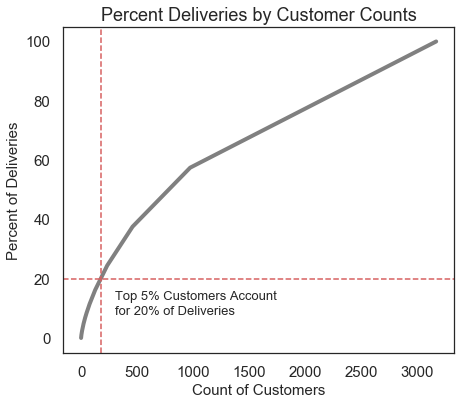

In [304]:
plt.figure(figsize=(7,6))
plt.plot(x,np.asarray(ratios)*100,color='grey',linewidth=4)
plt.ylabel('Percent of Deliveries',fontsize=15)
plt.xlabel('Count of Customers',fontsize=15)
plt.title('Percent Deliveries by Customer Counts',fontsize=18)
plt.axhline(20,color='r',linestyle='--')
plt.axvline(176,color='r',linestyle='--')
plt.text(300,13,'Top 5% Customers Account',fontsize=13)
plt.text(300,8,'for 20% of Deliveries',fontsize=13)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [303]:
df_delivery_lt_11['customer_id'].value_counts().sum()/df_delivery_lt_11['customer_id'].value_counts().shape[0]

1.6273644388398487

In [348]:
import pandas_profiling
df = pd.read_csv('data/analyze_me.csv')
pandas_profiling.ProfileReport(df)

In [353]:
(df_final['time_start_to_pickup']<0).sum() / df_final.shape[0]

0.08379420144126026